# Bus Stop Distance Example

This example will show how to use the Models API to find the nearest bus stop to each lot, and then mark the lot with two attributes:

* `bus_stop_name`: The name of the bus stop
* `bus_stop_distance`: The distance from the bus stop to the edge of the lot (or 0 if the bus stop is within the boundary of the lot)

## Examining the inputs

The `bus_stops` table has point locations for bus stops across the city, as well as a `stop_name` field which indicates the name of each stop. The image below shows some bus stop locations labeled with their `stop_name` attribute.

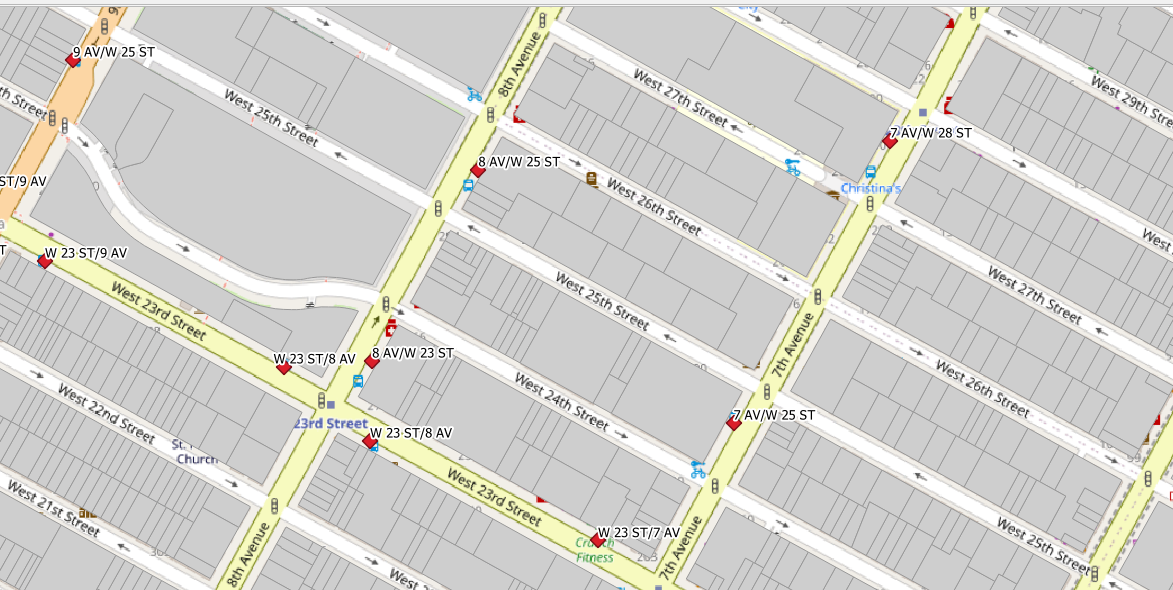

The table below shows the entire list of attributes available in the `bus_stops` table.

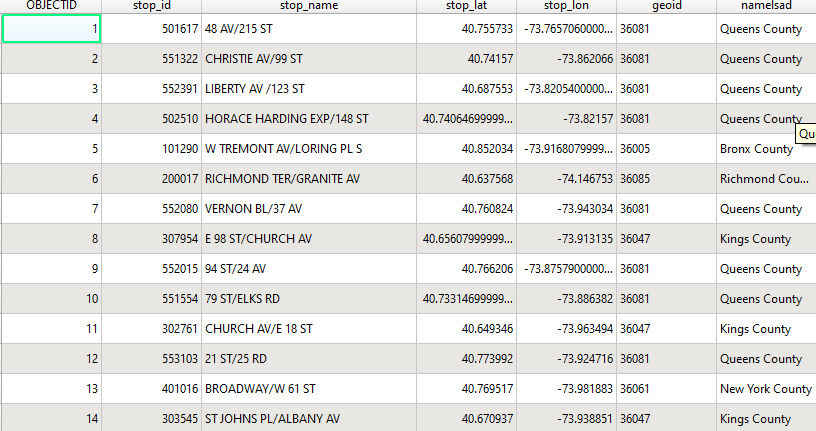

## Calculating bus stop name and distance

### Import the necessary objects

This example will use the `Workspace` object to make database connections and the `Layer` object to gain access to the required datasets.

In [1]:
# import the required objects
from envelopegis.models.workspace import Workspace
from envelopegis.models.layer import Layer

### Connect to the database and access the datasets

For this example I have loaded the two required datasets into a database called "bus_stop_sample" in our processing database. This snippit of code will connect to the database and load `Layer` objects for accessing the datasets.

In [2]:
# credentials for connecting to sample data
credentials = {
    'host': 'gisbox.ehq',
    'port': 7602,
    'database': 'bus_stop_sample',
    'user': 'postgres',
    'password': ''
}

# connect to the database
workspace = Workspace(credentials)

# load the required tables
primary_lots = Layer('primary_lots', workspace)
bus_stops = Layer('bus_stops', workspace)


### Add new fields to the primary lots table

We'll add two new fields to the primary lots table to hold our outputs.

In [3]:
# add fields to the primary lots layer to hold our findings
primary_lots.add_field('bus_stop_name', 'TEXT', field_length=100)
primary_lots.add_field('bus_stop_distance', 'FLOAT', default_value=0)

### Find the nearest bus stop for each lot

In the code below we will loop through each record in the `primary_lots` table using an update cursor and update each record with the name of and distance to the nearest bust stop.

In [ ]:
# loop through the primary lots layer and flag each lot

with primary_lots.get_update_cursor([primary_lots.shape, 'bus_stop_name', 'bus_stop_distance']) as cursor:
    for row in cursor:
        
        # find the nearest bus stop to this lot
        stop_oid, stop_point = bus_stops.nearest_item(row[primary_lots.shape])
        
        # use the object id to query out the name of the stop
        bus_stops.select_layer_by_attribute(stop_oid)
        with bus_stops.get_search_cursor('stop_name') as search_cursor:
            row['bus_stop_name'] = next(search_cursor)['stop_name']
        bus_stops.clear_selection()
        
        # use the bus stop point to calculate the distance
        row['bus_stop_distance'] = row[primary_lots.shape].distance_to(stop_point)
        
        # update the new values in the table
        cursor.update_row(row)

## Examining the outputs

The table below show a portion of the `primary_lots` table with values calculated for the `bus_stop_name` and `bus_stop_distance` fields.

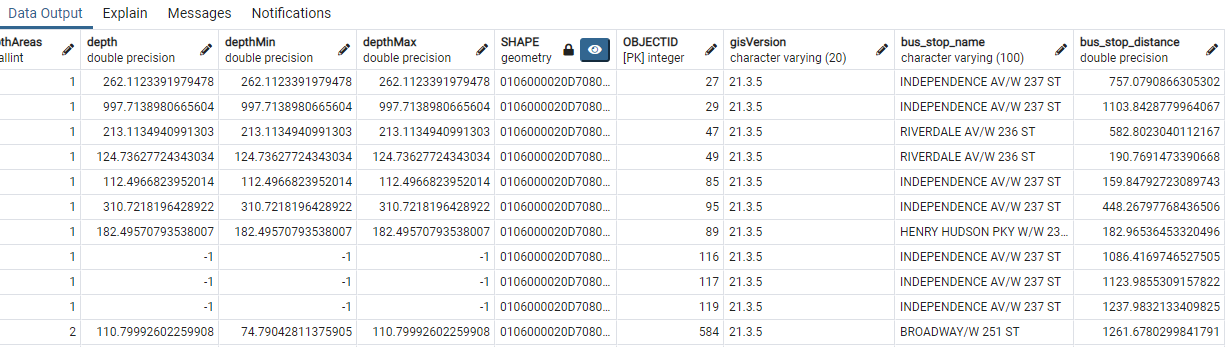